In [1]:
import torch
import matplotlib.pyplot as plt
from botorch.utils.sampling import draw_sobol_samples
from botorch.test_functions.synthetic import Ackley

In [2]:
ackley = Ackley(dim=1)

def mo_problem(x):
    def forrester(x):
        return torch.sin(3*x) + x**2 - 0.7*x
    return torch.concat([forrester(x), ackley(x).unsqueeze(1)], dim=1)

tkwargs = {"device": "cpu:0", "dtype": torch.double}
bounds = torch.tensor([[-1.], [2.]], **tkwargs)

In [3]:
x_dense = torch.linspace(bounds[0].item(), bounds[1].item(), 100, **tkwargs).unsqueeze(1)
y_dense = mo_problem(x_dense)

fidelities = [0, 1, 2]

def generate_initial_data(n=6):
    x = draw_sobol_samples(bounds=bounds, n=n, q=1).squeeze(1)
    fid = torch.randint(3, [n, 1])
    y = mo_problem(x)
    x = torch.concat([x, fid], dim=1)
    return x, y

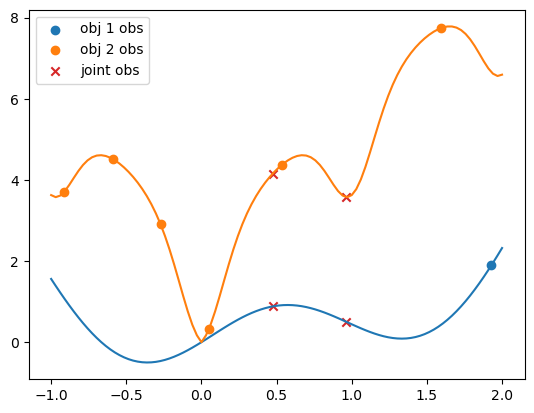

In [4]:
x_obs, y_obs = generate_initial_data(n=9)

plt.plot(x_dense, y_dense[:, 0])
plt.plot(x_dense, y_dense[:, 1])
plt.scatter(x_obs[x_obs[:, -1] == 0][:, 0], y_obs[x_obs[:, -1] == 0][:, 0], label='obj 1 obs')
plt.scatter(x_obs[x_obs[:, -1] == 1][:, 0], y_obs[x_obs[:, -1] == 1][:, 1], label='obj 2 obs')
plt.scatter(x_obs[x_obs[:, -1] == 2][:, 0], y_obs[x_obs[:, -1] == 2][:, 0], marker='x', color="tab:red")
plt.scatter(x_obs[x_obs[:, -1] == 2][:, 0], y_obs[x_obs[:, -1] == 2][:, 1], label='joint obs', marker='x', color="tab:red")
plt.legend();

In [5]:
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood, SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize

In [6]:
x_norm = normalize(x_obs[:, :1], bounds)

def single_objective_gp(x_obs, y_obs):
    model = SingleTaskGP(
        x_obs, y_obs, outcome_transform=Standardize(m=1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

model1 = single_objective_gp(x_norm[x_obs[:, -1] == 0], y_obs[x_obs[:, -1] == 0][:, :1])
model2 = single_objective_gp(x_norm[x_obs[:, -1] == 1], y_obs[x_obs[:, -1] == 1][:, -1:])
models = [model1, model2]
model_base = ModelListGP(*models)

In [7]:
def joint_objective_gp(x_obs, y_obs):
    models = []
    # build a GP model for each objective
    for i in range(y_obs.shape[-1]):
        models.append(
            SingleTaskGP(
                x_obs, y_obs[..., i:i+1], outcome_transform=Standardize(m=1)
            )
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return model

model_joint = joint_objective_gp(x_norm[x_obs[:, 1] == 2], y_obs[x_obs[:, 1] == 2])

In [8]:
with torch.no_grad():
    posterior_base = model_base.posterior(x_norm[x_obs[:, 1] == 2])

res_joint = (y_obs[x_obs[:, 1] == 2] - posterior_base.mean) / posterior_base.variance.sqrt()
model_res = joint_objective_gp(x_norm[x_obs[:, 1] == 2], res_joint)

In [9]:
full_model1 = single_objective_gp(x_norm[x_obs[:, -1] != 1][:, :1], y_obs[x_obs[:, -1] != 1][:, :1])
full_model2 = single_objective_gp(x_norm[x_obs[:, -1] != 0][:, :1], y_obs[x_obs[:, -1] != 0][:, -1:])
models = [full_model1, full_model2]
model_full = ModelListGP(*models)

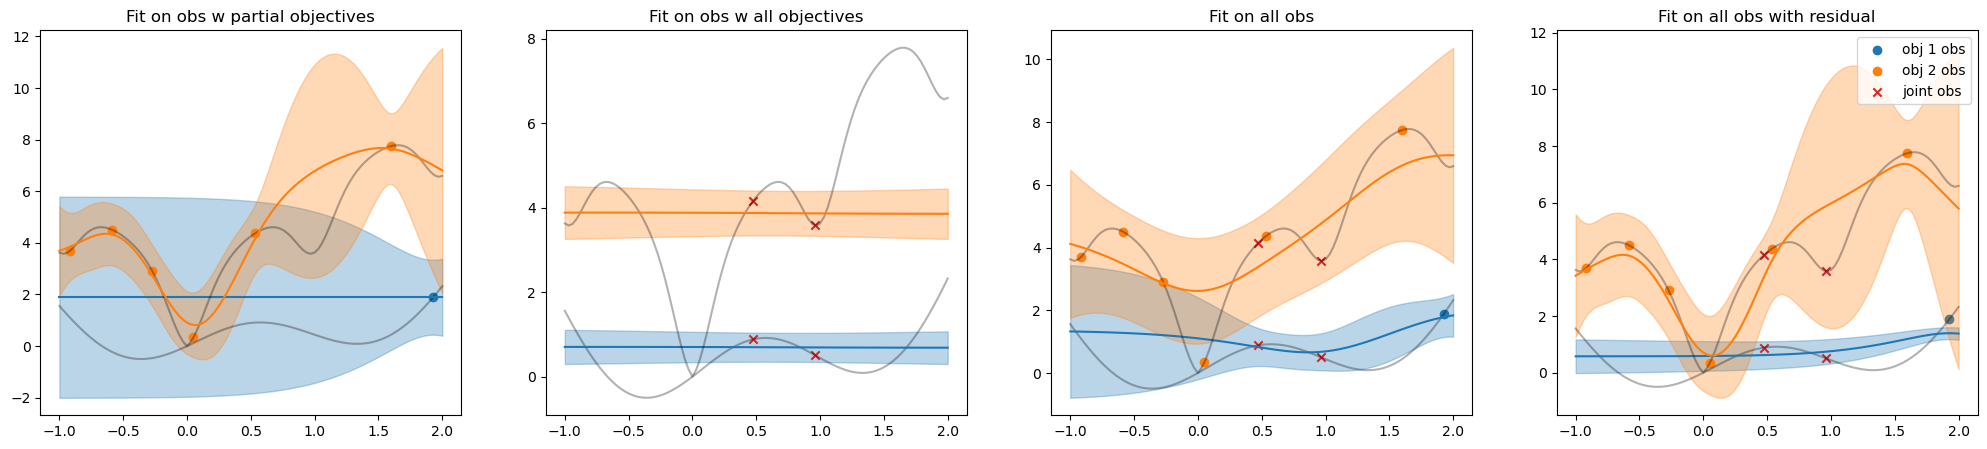

In [10]:
figure = plt.figure(figsize=(25, 5))

ax_sep = plt.subplot2grid((1, 4), (0, 0))

x_dense_norm = normalize(x_dense, bounds)
with torch.no_grad():
    posterior = model_base.posterior(x_dense_norm)

for i, color in zip([0, 1], ["tab:blue", "tab:orange"]):
    ax_sep.plot(x_dense, y_dense[:, i], color='k', alpha=.3)
    ax_sep.plot(x_dense, posterior.mean[:, i], color=color)
    ax_sep.fill_between(
        x_dense.squeeze(),
        (posterior.mean[:, i] - 2 * posterior.variance[:, i].sqrt()).squeeze(),
        (posterior.mean[:, i] + 2 * posterior.variance[:, i].sqrt()).squeeze(),
        alpha=.3,
        color=color
    )
    ax_sep.scatter(x_obs[x_obs[:, -1] == i][:, 0], y_obs[x_obs[:, -1] == i][:, i], label=f'obj {i+1} obs')

ax_sep.set_title("Fit on obs w partial objectives")


ax_joint = plt.subplot2grid((1, 4), (0, 1))
with torch.no_grad():
    posterior_joint = model_joint.posterior(x_dense_norm)

for i, color in zip([0, 1], ["tab:blue", "tab:orange"]):
    ax_joint.plot(x_dense, y_dense[:, i], color='k', alpha=.3)
    ax_joint.plot(x_dense, posterior_joint.mean[:, i], color=color)
    ax_joint.fill_between(
        x_dense.squeeze(),
        (posterior_joint.mean[:, i] - 2 * posterior_joint.variance[:, i].sqrt()).squeeze(),
        (posterior_joint.mean[:, i] + 2 * posterior_joint.variance[:, i].sqrt()).squeeze(),
        alpha=.3,
        color=color
    )

ax_joint.scatter(x_obs[x_obs[:, -1] == 2][:, 0], y_obs[x_obs[:, -1] == 2][:, 0], marker='x', color="tab:red")
ax_joint.scatter(x_obs[x_obs[:, -1] == 2][:, 0], y_obs[x_obs[:, -1] == 2][:, 1], label='joint obs', marker='x', color="tab:red")
ax_joint.set_title("Fit on obs w all objectives")

ax_full = plt.subplot2grid((1, 4), (0, 2))
with torch.no_grad():
    posterior = model_full.posterior(x_dense_norm)

for i, color in zip([0, 1], ["tab:blue", "tab:orange"]):
    ax_full.plot(x_dense, y_dense[:, i], color='k', alpha=.3)
    ax_full.plot(x_dense, posterior.mean[:, i], color=color)
    ax_full.fill_between(
        x_dense.squeeze(),
        (posterior.mean[:, i] - 2 * posterior.variance[:, i].sqrt()).squeeze(),
        (posterior.mean[:, i] + 2 * posterior.variance[:, i].sqrt()).squeeze(),
        alpha=.3,
        color=color
    )
    ax_full.scatter(x_obs[x_obs[:, -1] == i][:, 0], y_obs[x_obs[:, -1] == i][:, i], label=f'obj {i+1} obs')
    ax_full.scatter(x_obs[x_obs[:, -1] == 2][:, 0], y_obs[x_obs[:, -1] == 2][:, i], label='joint obs' if i else None, marker='x', color="tab:red")
ax_full.set_title("Fit on all obs")

ax_res = plt.subplot2grid((1, 4), (0, 3))
with torch.no_grad():
    posterior_base = model_base.posterior(x_dense_norm)
    posterior_res = model_res.posterior(x_dense_norm)

mean = posterior_res.mean * posterior_base.variance.sqrt() + posterior_base.mean
variance = posterior_res.variance * posterior_base.variance

for i, color in zip([0, 1], ["tab:blue", "tab:orange"]):
    ax_res.plot(x_dense, y_dense[:, i], color='k', alpha=.3)
    ax_res.plot(x_dense, mean[:, i], color=color)
    ax_res.fill_between(
        x_dense.squeeze(),
        (mean[:, i] - 2 * variance[:, i].sqrt()).squeeze(),
        (mean[:, i] + 2 * variance[:, i].sqrt()).squeeze(),
        alpha=.3,
        color=color
    )
    ax_res.scatter(x_obs[x_obs[:, -1] == i][:, 0], y_obs[x_obs[:, -1] == i][:, i], label=f'obj {i+1} obs')
    ax_res.scatter(x_obs[x_obs[:, -1] == 2][:, 0], y_obs[x_obs[:, -1] == 2][:, i], label='joint obs' if i else None, marker='x', color="tab:red")
ax_res.set_title("Fit on all obs with residual")

plt.legend();

In [11]:
# cost obj1:obj2:full = 1:3:4
def observe_and_suggest(model_base, model_res, n=2000):
    cost = torch.tensor([1, 3, 4])
    standard_bound = torch.tensor([[0.], [1.]])
    candidates = draw_sobol_samples(bounds=standard_bound, n=n, q=1).squeeze(1)
    with torch.no_grad():
        posterior_base = model_base.posterior(candidates)
        posterior_res = model_res.posterior(candidates)

    std = (posterior_res.variance * posterior_base.variance).sqrt()
    std1 = std[:, :1]
    std2 = std[:, -1:]
    # std1 = posterior_base.variance[:, 0].sqrt().unsqueeze(1)
    # std2 = posterior_base.variance[:, 1].sqrt().unsqueeze(1)
    std_res = std.sum(dim=1).unsqueeze(1)
    uncertainty = torch.concat([std1, std2, std_res], dim=1)
    uncertainty_per_cost = uncertainty / cost

    _, ind = uncertainty_per_cost.view(1, -1).max(-1)
    new_x = candidates[torch.floor_divide(ind, 3)]
    fidelity = torch.tensor([[ind % 3]])
    return new_x, fidelity

pos: 2.00, fidelity: 1


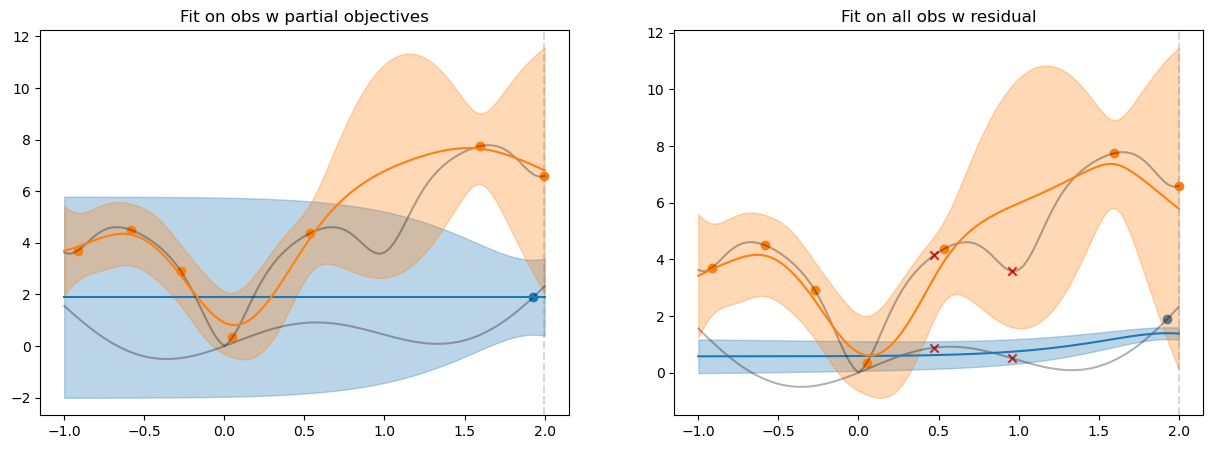

pos: 1.09, fidelity: 1


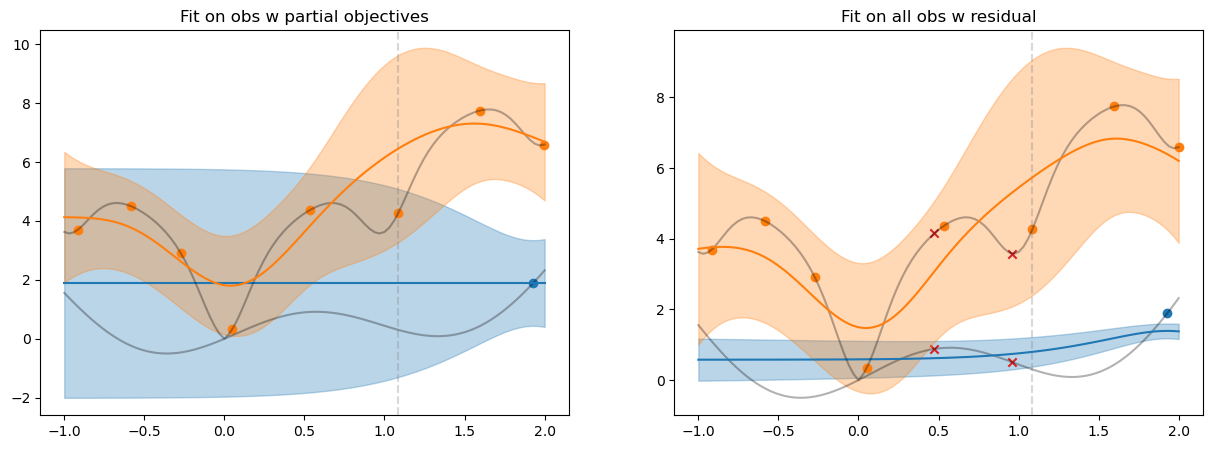

pos: -1.00, fidelity: 1


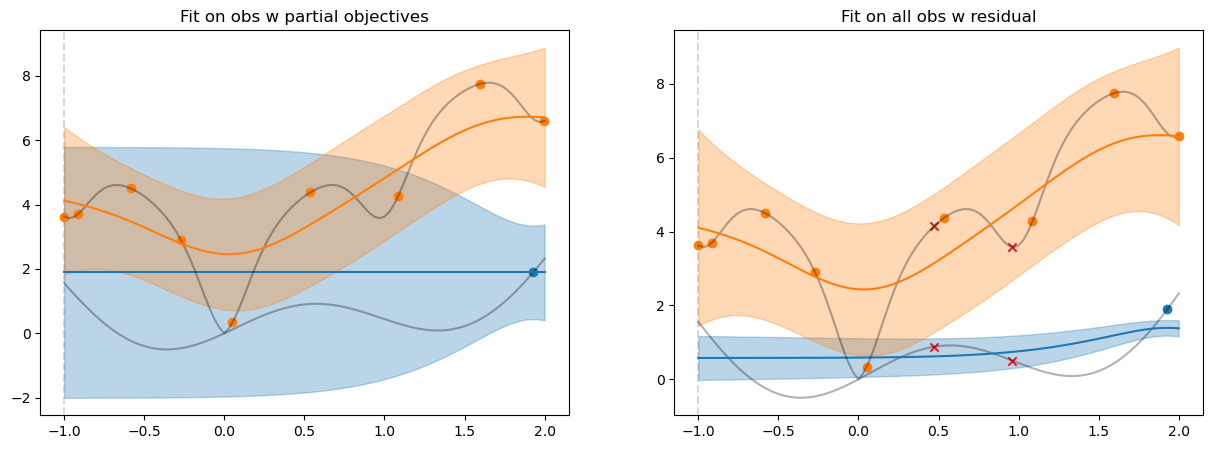

pos: -1.00, fidelity: 0


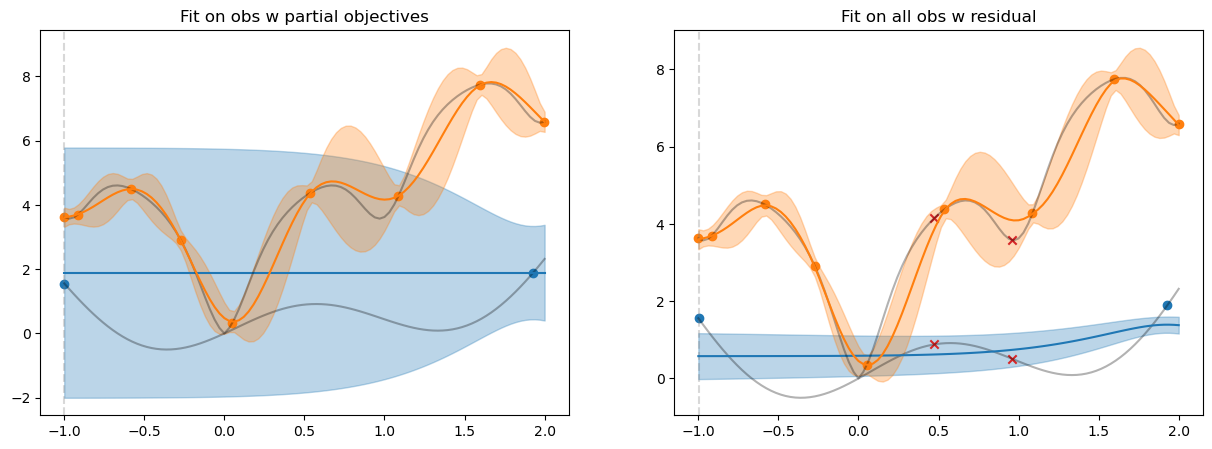

pos: 0.32, fidelity: 0


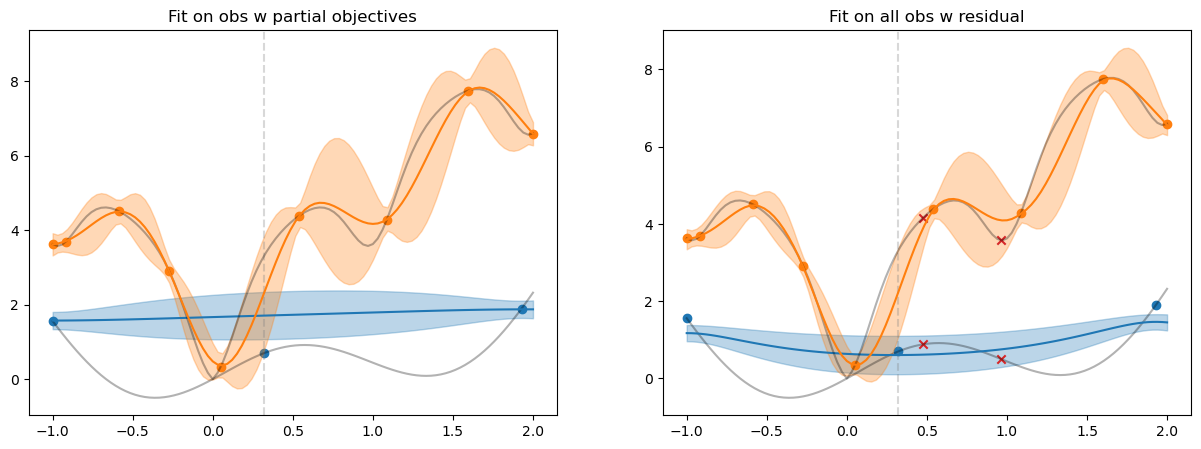

pos: 1.16, fidelity: 0


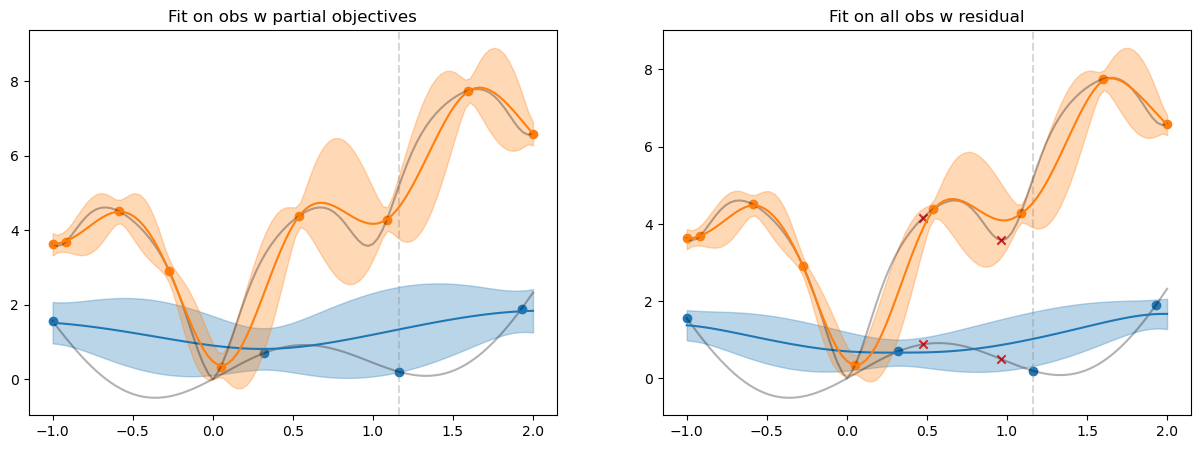

pos: 0.81, fidelity: 1


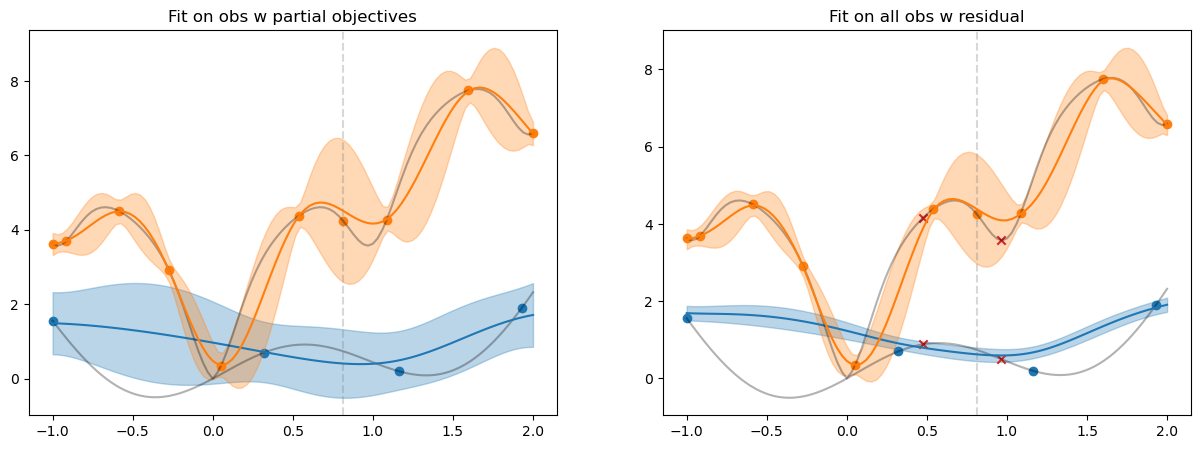

pos: 2.00, fidelity: 1


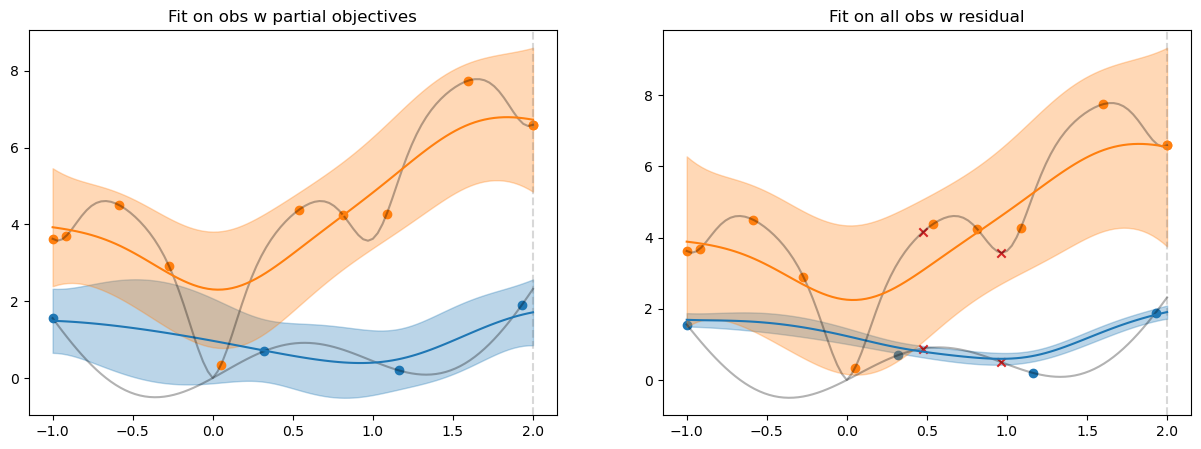

pos: 1.35, fidelity: 1


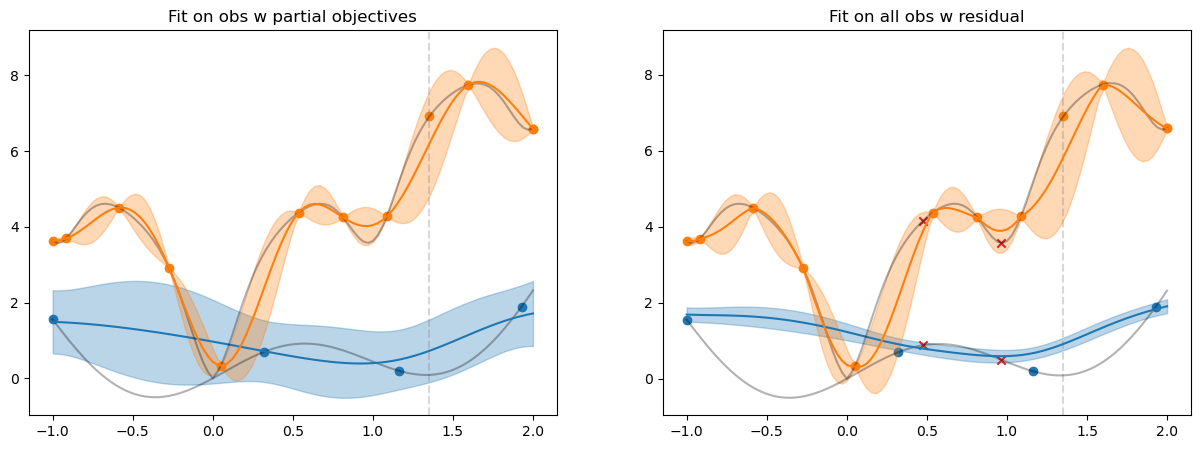

pos: 0.29, fidelity: 1


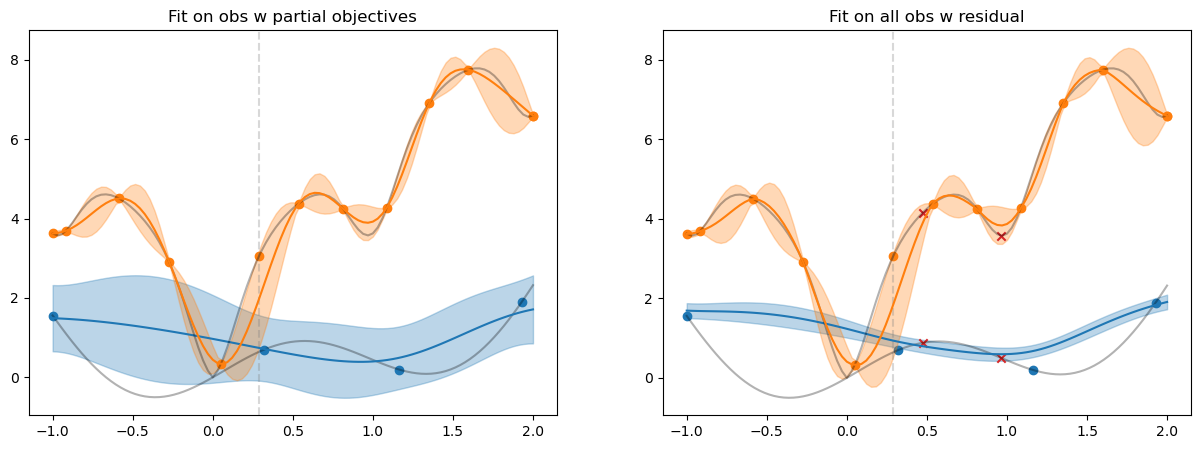

pos: -0.38, fidelity: 0


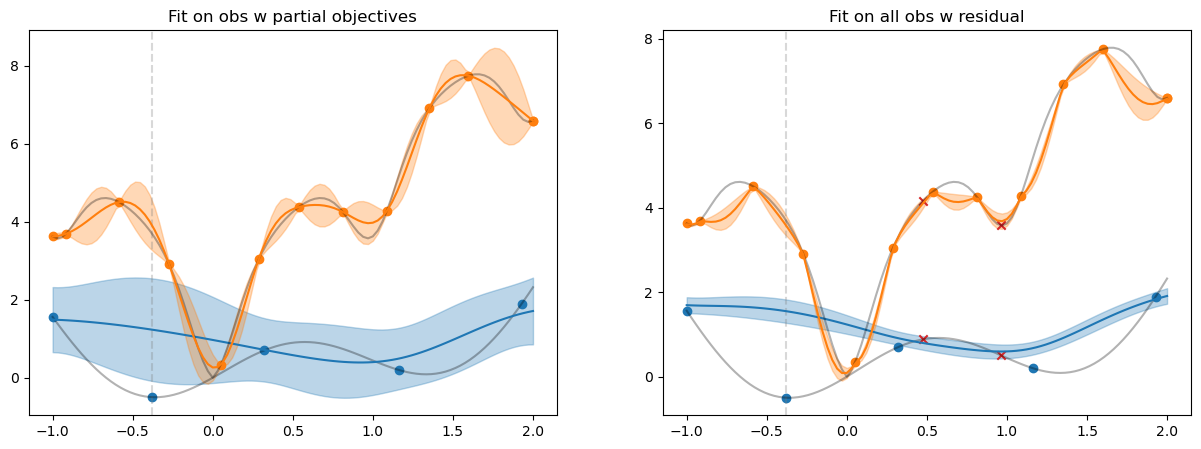

pos: 2.00, fidelity: 0


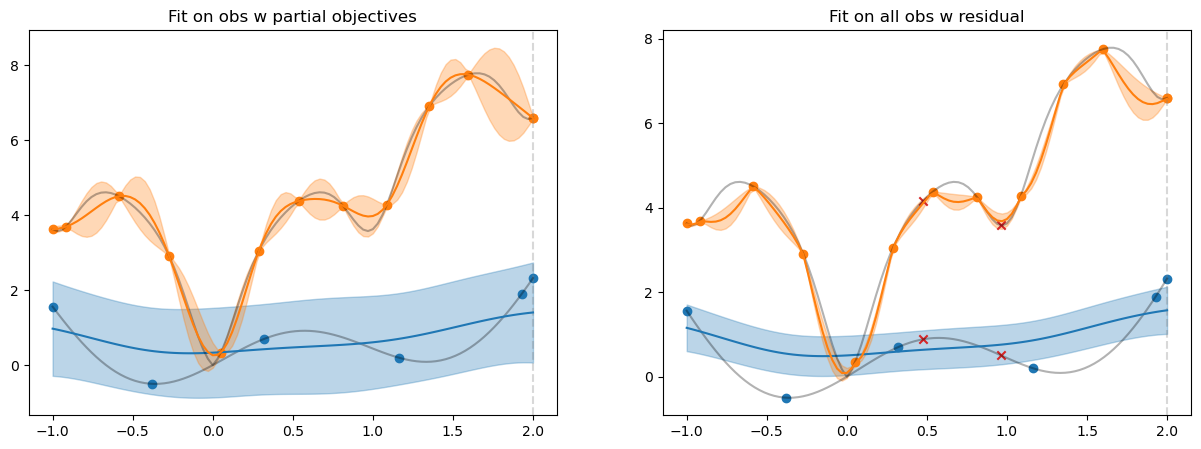

pos: 1.81, fidelity: 1


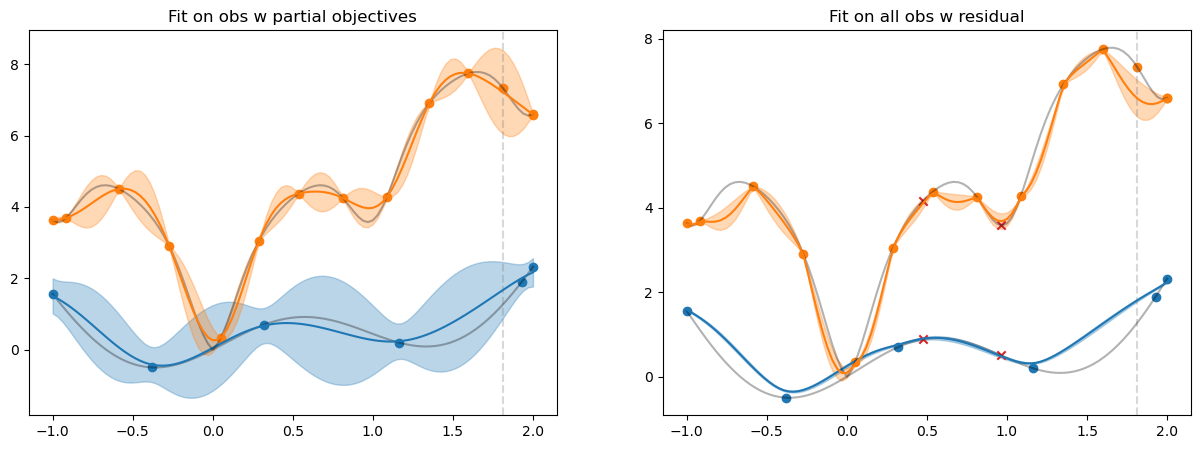

pos: -0.43, fidelity: 1


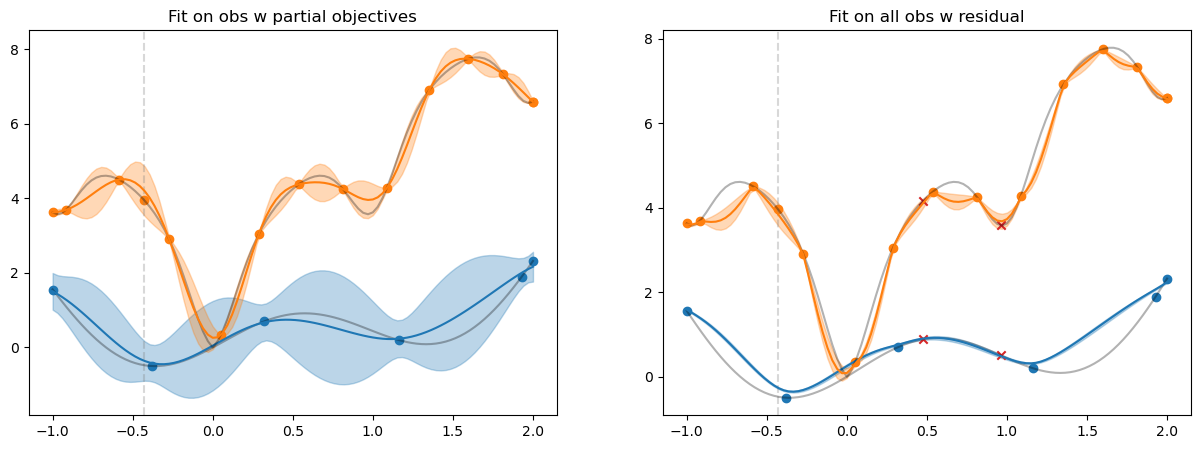

pos: -0.11, fidelity: 1


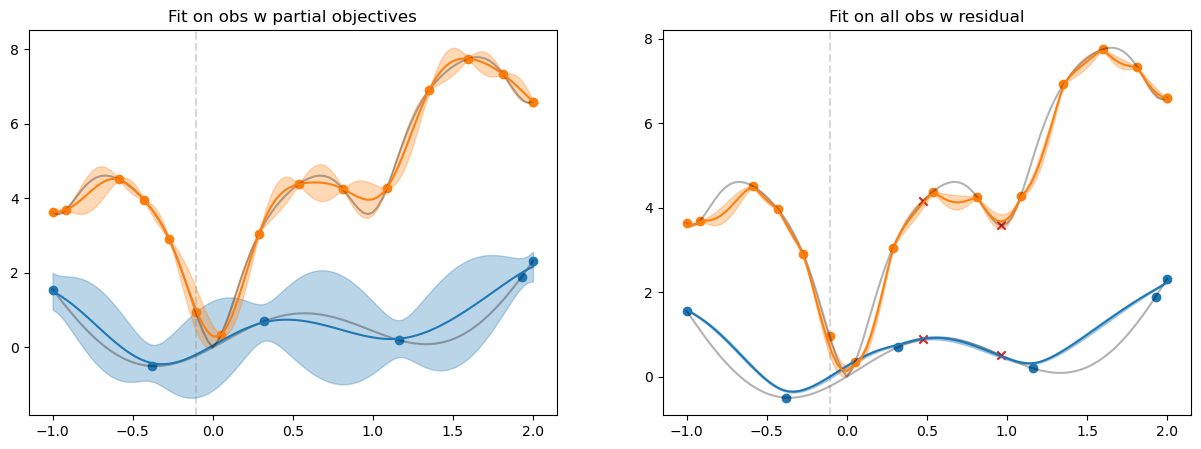

pos: -0.75, fidelity: 1


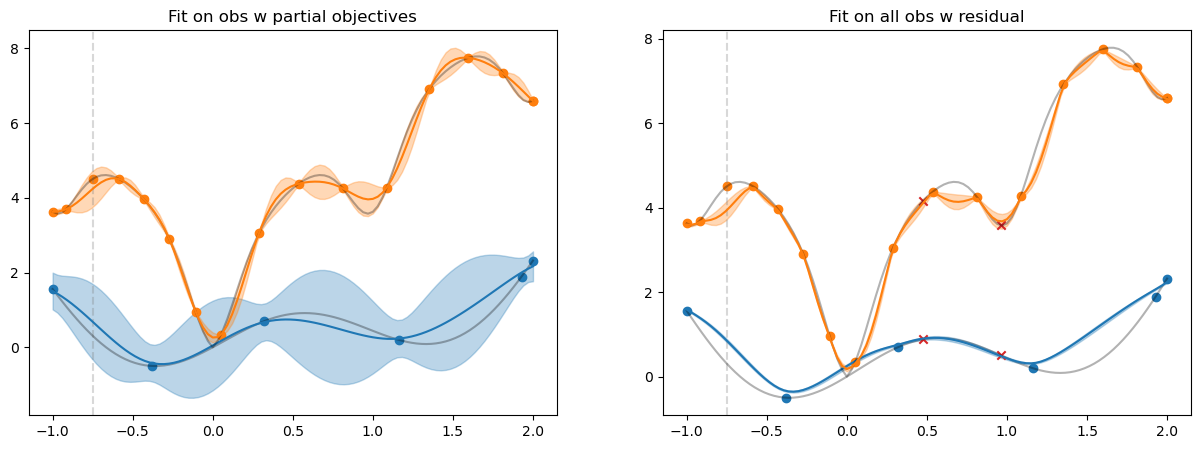

pos: 0.95, fidelity: 1


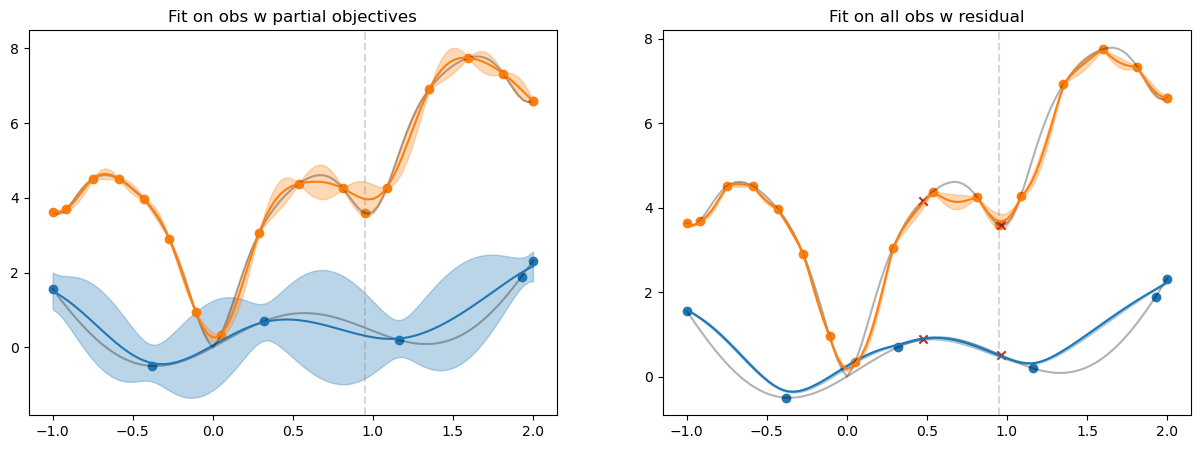

pos: 0.74, fidelity: 0


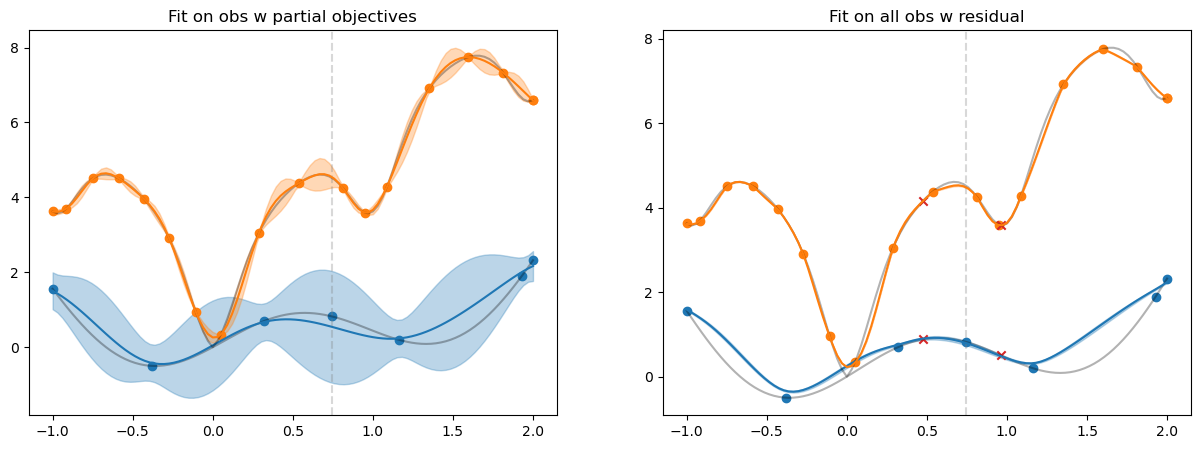

pos: 1.57, fidelity: 0


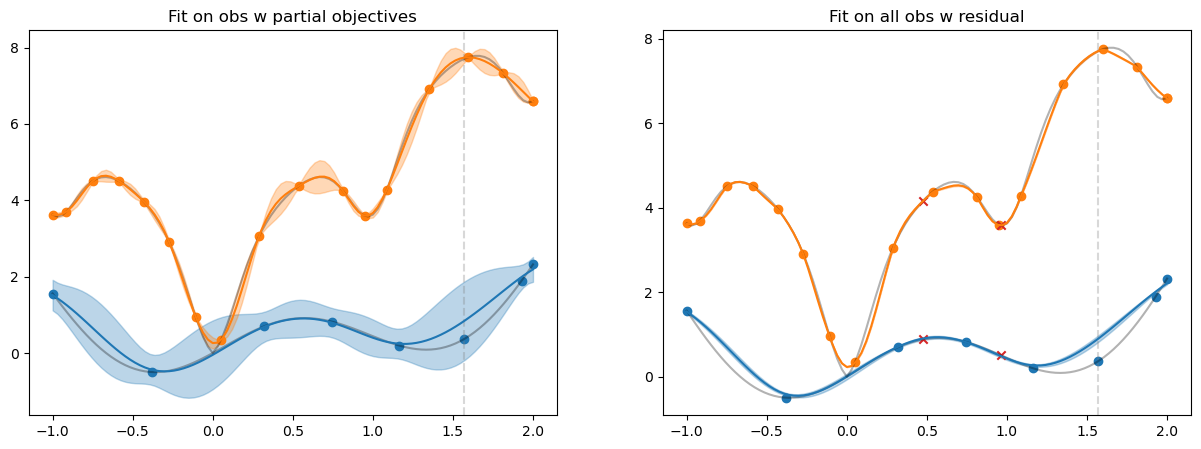

pos: -0.71, fidelity: 0


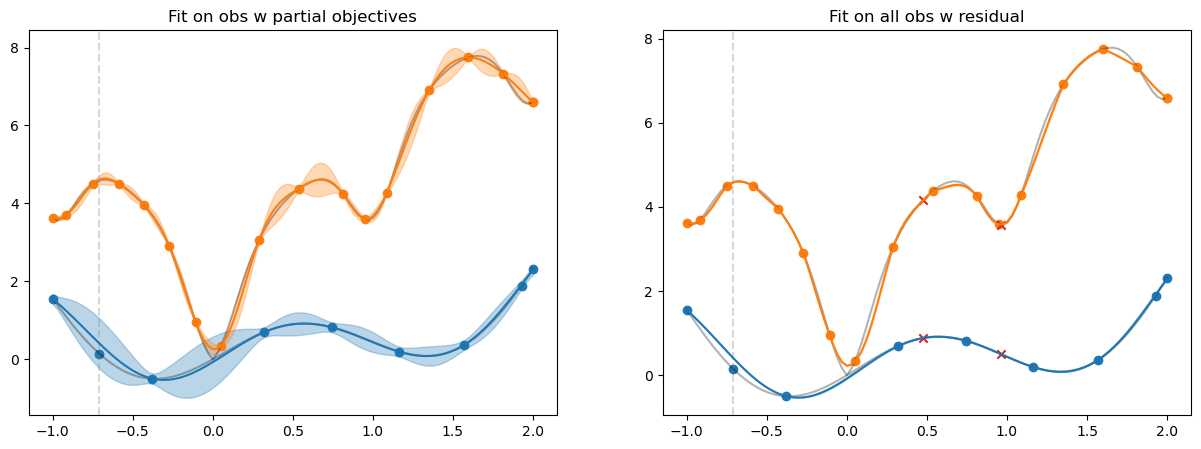

In [12]:
for _ in range(20):
    x_norm = normalize(x_obs[:, :1], bounds)

    model1 = single_objective_gp(x_norm[x_obs[:, -1] == 0], y_obs[x_obs[:, -1] == 0][:, :1])
    model2 = single_objective_gp(x_norm[x_obs[:, -1] == 1], y_obs[x_obs[:, -1] == 1][:, -1:])
    models = [model1, model2]
    model_base = ModelListGP(*models)

    with torch.no_grad():
        posterior_base = model_base.posterior(x_norm[x_obs[:, 1] == 2])
    res_joint = (y_obs[x_obs[:, 1] == 2] - posterior_base.mean) / posterior_base.variance.sqrt()
    model_res = joint_objective_gp(x_norm[x_obs[:, 1] == 2], res_joint)

    new_x, fidelity = observe_and_suggest(model_base=model_base, model_res=model_res)
    new_x = unnormalize(new_x, bounds=bounds)
    print(f"pos: {new_x.item():.2f}, fidelity: {fidelity.item()}")
    new_y = mo_problem(new_x)
    x_obs = torch.concat([x_obs, torch.concat([new_x, fidelity], dim=1)], dim=0)
    y_obs = torch.concat([y_obs, new_y], dim=0)

    fig = plt.figure(figsize=(15, 5))
    ax_sep = plt.subplot2grid((1, 2), (0, 0))
    with torch.no_grad():
        posterior = model_base.posterior(x_dense_norm)

    ax_sep.axvline(x=new_x, linestyle='--', color='tab:gray', alpha=.3)
    for i, color in zip([0, 1], ["tab:blue", "tab:orange"]):
        ax_sep.plot(x_dense, y_dense[:, i], color='k', alpha=.3)
        ax_sep.plot(x_dense, posterior.mean[:, i], color=color)
        ax_sep.fill_between(
            x_dense.squeeze(),
            (posterior.mean[:, i] - 2 * posterior.variance[:, i].sqrt()).squeeze(),
            (posterior.mean[:, i] + 2 * posterior.variance[:, i].sqrt()).squeeze(),
            alpha=.3,
            color=color
        )
        ax_sep.scatter(x_obs[x_obs[:, -1] == i][:, 0], y_obs[x_obs[:, -1] == i][:, i], label=f'obj {i+1} obs')

    ax_sep.set_title("Fit on obs w partial objectives")

    ax_res = plt.subplot2grid((1, 2), (0, 1))
    with torch.no_grad():
        posterior_base = model_base.posterior(x_dense_norm)
        posterior_res = model_res.posterior(x_dense_norm)

    mean = posterior_res.mean * posterior_base.variance.sqrt() + posterior_base.mean
    variance = posterior_res.variance * posterior_base.variance
    ax_res.axvline(x=new_x, linestyle='--', color='tab:gray', alpha=.3)

    for i, color in zip([0, 1], ["tab:blue", "tab:orange"]):
        ax_res.plot(x_dense, y_dense[:, i], color='k', alpha=.3)
        ax_res.plot(x_dense, mean[:, i], color=color)
        ax_res.fill_between(
            x_dense.squeeze(),
            (mean[:, i] - 2 * variance[:, i].sqrt()).squeeze(),
            (mean[:, i] + 2 * variance[:, i].sqrt()).squeeze(),
            alpha=.3,
            color=color
        )
        ax_res.scatter(x_obs[x_obs[:, -1] == i][:, 0], y_obs[x_obs[:, -1] == i][:, i], label=f'obj {i+1} obs')
        ax_res.scatter(x_obs[x_obs[:, -1] == 2][:, 0], y_obs[x_obs[:, -1] == 2][:, i], label='joint obs' if i else None, marker='x', color="tab:red")

    ax_res.set_title("Fit on all obs w residual")
    plt.show()